In [ ]:
!pip install arch==4.19

     |████████████████████████████████| 807 kB 16.8 MB/s 
     |████████████████████████████████| 2.0 MB 75.6 MB/s 
     |████████████████████████████████| 9.5 MB 51.6 MB/s 
     |████████████████████████████████| 231 kB 75.7 MB/s 


In [ ]:
!pip install investpy==1.0.6

     |████████████████████████████████| 4.4 MB 19.7 MB/s 
     |████████████████████████████████| 241 kB 69.3 MB/s 
  Created wheel for investpy: filename=investpy-1.0.6-py3-none-any.whl size=4485152 sha256=ae70af1a42dfce6bf374cfbae9ad5360faccc7e96dead333b08fc6f87167b6f1
  Stored in directory: /root/.cache/pip/wheels/bc/a3/1b/8d71d8907ca0e79cb0a82139f3661cb577ced0fd8bbb7b6c7f
Successfully built investpy


In [ ]:
# Start writing code here...
import numpy as np
import pandas as pd
from arch import arch_model
import investpy
import matplotlib.pyplot as plt

In [ ]:
    TSLA = investpy.get_stock_historical_data(stock='TSLA',
                                        country='United States',
                                        from_date='01/04/2011',
                                        to_date='01/04/2021')
    ING = investpy.get_stock_historical_data(stock='INGA',
                                        country='Netherlands',
                                        from_date='01/04/2011',
                                        to_date='01/04/2021')
    Pfizer= investpy.get_stock_historical_data(stock='PFE',
                                        country='United States',
                                        from_date='01/04/2011',
                                        to_date='01/04/2021')
    SP500=investpy.get_index_historical_data(index='s&p 500',
                                    country='United States',
                                    from_date='01/04/2011',
                                    to_date='01/04/2021')
    euro_usd = investpy.get_currency_cross_historical_data(currency_cross='EUR/USD',
                                                    from_date='01/04/2011',
                                                    to_date='01/04/2021')
    bond=investpy.get_bond_historical_data('Netherlands 10Y',
                                    from_date='01/04/2011',
                                    to_date='01/04/2021')
    
    data=pd.DataFrame({'TSLA':TSLA.Close,'ING':ING.Close,'Pfizer':Pfizer.Close,'SP500':SP500.Close,'FX':euro_usd.Close,'bond':bond.Close})
    data=data.dropna() # synchronize
    data['ING']=data['ING']*data['FX'] # change currency
    data['bond']=data['bond']*data['FX'] # change currency
    # everything in USD

In [ ]:
# Log return
L=pd.DataFrame(columns=['TSLA','ING','Pfizer','SP500','bond'])
L['TSLA']=np.log(data['TSLA']).diff() # log return
L['ING']=np.log(data['ING']).diff()
L['Pfizer']=np.log(data['Pfizer']).diff()
L['SP500']=np.log(data['SP500']).diff()
L['bond']=data['bond'].diff() 
L['bond']=L['bond']/100 #change yield
L['y']=data['bond']
L=L.dropna() # remove first row
# compute everyday portfolio loss, last column
L['loss']=L.apply(lambda r: 0.15*(1-np.exp(r.TSLA))+\
                            0.15*(1-np.exp(r.ING))+\
                            0.15*(1-np.exp(r.Pfizer))+\
                            0.15*(1-np.exp(r.SP500))\
                           -0.4*(1-np.exp(-r.bond))+\
                            0.4*r.y / 25000,
                            axis=1) # without time to maturity
L

,TSLA,ING,Pfizer,SP500,bond,y,loss
Date,,,,,,,
2011-04-04,-0.030479,-0.011586,0.007820,0.000345,-0.000218,5.192452,0.005171
2011-04-05,0.032353,-0.008779,-0.004391,-0.000180,0.000061,5.198506,-0.002878
2011-04-06,-0.007519,0.024234,-0.007855,0.002181,0.000932,5.291744,-0.001998
2011-04-07,0.027909,-0.006407,0.001969,-0.001521,-0.000207,5.271024,-0.003188
2011-04-08,-0.027909,0.024301,0.006374,-0.004013,0.001550,5.426031,-0.000453
...,...,...,...,...,...,...,...
2021-03-26,-0.034441,0.001732,0.016129,0.016494,0.000391,-0.340904,-0.000277
2021-03-29,-0.012065,-0.009807,0.010155,-0.000868,0.000363,-0.304636,0.001712
2021-03-30,0.039029,0.034826,-0.014025,-0.003163,0.000411,-0.263565,-0.008892


In [ ]:
start_loc = 0
window_size=250
step=2242

In [ ]:
pred_vars=pd.DataFrame(index=L.index)
for asset in L.columns[:5]:
    am = arch_model(L[asset], vol="Garch", p=1, o=0, q=1, dist="Normal")
    forecasts = {}
    for i in range(step):
        res = am.fit(first_obs=i, last_obs=i + window_size, disp="off")
        temp = res.forecast(horizon=1, reindex=False).variance
        #print(i,'temp',temp.shape)
        fcast = temp.iloc[0]
        #print(i,'fcast',fcast)
        forecasts[fcast.name] = fcast
    var=pd.DataFrame(forecasts).T
    pred_vars[asset]=var
pred_vars=pred_vars.dropna()

/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.813e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/v

In [ ]:
sigma=np.sqrt(pred_vars) 
sigma

,TSLA,ING,Pfizer,SP500,bond
Date,,,,,
2012-03-30,0.032004,0.029702,0.009605,0.006885,0.000778
2012-04-02,0.032266,0.027751,0.009271,0.007094,0.000772
2012-04-03,0.033132,0.030083,0.008982,0.006921,0.000761
2012-04-04,0.038235,0.033211,0.008950,0.008102,0.000749
2012-04-05,0.032549,0.032018,0.008906,0.007472,0.000739
...,...,...,...,...,...
2021-03-25,0.043489,0.025854,0.012744,0.009882,0.000340
2021-03-26,0.043953,0.025379,0.012898,0.011418,0.000341
2021-03-29,0.041447,0.024946,0.012842,0.010446,0.000339


In [ ]:
corr_matrix=L.iloc[:,:5].corr()
corr_matrix

,TSLA,ING,Pfizer,SP500,bond
TSLA,1.000000,0.233183,0.187400,0.418372,0.081003
ING,0.233183,1.000000,0.278327,0.518121,0.413326
Pfizer,0.187400,0.278327,1.000000,0.627317,0.141651
SP500,0.418372,0.518121,0.627317,1.000000,0.242476
bond,0.081003,0.413326,0.141651,0.242476,1.000000


In [ ]:
weights = np.array([0.15, 0.15, 0.15, 0.15, 0.4])
#weights=weights*1000000
cov=np.zeros([5,5])
VaRs=[]
for i in range(250,250+step):
    mean_loss= np.mean(L.loss[:i]) 
    print('mean loss before {} :'.format(i),mean_loss)
    # update cov matrix
    for r in range(corr_matrix.shape[0]):
        for c in range(corr_matrix.shape[1]):
            cov[r][c]=corr_matrix.to_numpy()[r][c]*sigma.to_numpy()[i-250][r]*sigma.to_numpy()[i-250][c]

    print('sigma:',np.sqrt(weights.T.dot(cov).dot(weights)))
    VaRs.append((mean_loss+ np.sqrt(weights.T.dot(cov).dot(weights))*1.96)*1000000) 

sigma: 0.00785874695323736
mean loss before 1993 : -0.00038784447947586443
sigma: 0.007640690256907629
mean loss before 1994 : -0.00039063370144830687
sigma: 0.007536711540794821
mean loss before 1995 : -0.0003847777301024956
sigma: 0.00839492323324712
mean loss before 1996 : -0.0003866428694986956
sigma: 0.007934950341570348
mean loss before 1997 : -0.00038646196806262014
sigma: 0.0075703253096859125
mean loss before 1998 : -0.00038517935038765734
sigma: 0.007511483750236711
mean loss before 1999 : -0.0003856944717137106
sigma: 0.007398452210390497
mean loss before 2000 : -0.00038383238894346806
sigma: 0.00758165585464652
mean loss before 2001 : -0.00038617734933137993
sigma: 0.007630651257183662
mean loss before 2002 : -0.00038676981895846406
sigma: 0.007838820230311913
mean loss before 2003 : -0.000386986135221602
sigma: 0.008025558839402631
mean loss before 2004 : -0.0003839218781491653
sigma: 0.008176732549040801
mean loss before 2005 : -0.0003831865532506782
sigma: 0.008003651381

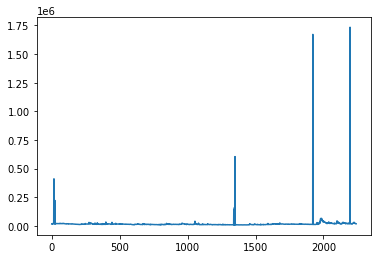

In [ ]:
plt.plot(VaRs)
#plt.ylim(top=40000)

(0.0, 100000.0)

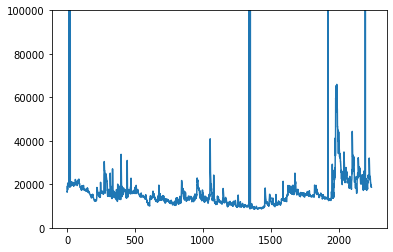

In [ ]:
plt.plot(VaRs)
plt.ylim(bottom=0,top=100000)

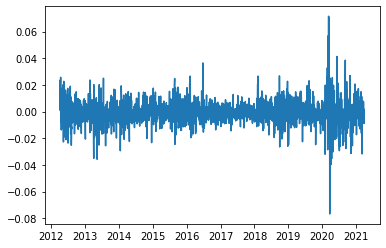

In [ ]:
plt.plot(L.loss[250:])

In [ ]:
from arch.univariate import EWMAVariance
rm=EWMAVariance(0.94)

In [ ]:
rm.compute_variance()

TypeError: compute_variance() missing 5 required positional arguments: 'parameters', 'resids', 'sigma2', 'backcast', and 'var_bounds'

In [ ]:
investpy.get_indices(country='United States')

,country,name,full_name,symbol,currency,class,market
0,united states,NQ US Mid Cap Value,NASDAQ US Mid Cap Value,NQUSMV,USD,other_indices,global_indices
1,united states,NQ US Mid Cap Growth,NASDAQ US Mid Cap Growth,NQUSMG,USD,other_indices,global_indices
2,united states,NQ US Mid Cap Telecommunications Equipment,NASDAQ US Mid Cap Telecommunications Equipment,NQUSM9578,USD,other_indices,global_indices
3,united states,NQ US Mid Cap Semiconductors,NASDAQ US Mid Cap Semiconductors,NQUSM9576,USD,other_indices,global_indices
4,united states,NQ US Mid Cap Computer Hardware,NASDAQ US Mid Cap Computer Hardware,NQUSM9572,USD,other_indices,global_indices
...,...,...,...,...,...,...,...
1373,united states,DJ Internet,Dow Jones Internet,DJUSNS,USD,other_indices,world_indices
1374,united states,DJ Integrated Oil & Gas,Dow Jones Integrated Oil & Gas,DJUSOL,USD,other_indices,world_indices
1375,united states,DJ Insurance Brokers,Dow Jones Insurance Brokers,DJUSIB,USD,other_indices,world_indices
1376,united states,NQ OMX Green Economy ex-US TR USD,NASDAQ OMX Green Economy ex-US TR USD,GRNEXUSX,USD,other_indices,world_indices


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=645d3506-ee2c-44c9-a8e9-fa6f8711818a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>